In [32]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

import cartopy.crs as ccrs
import cartopy as cart
import cmocean
import torch
import torch.nn as nn
import torch.utils.data as data
import torch_geometric
from torch.nn import Sequential as Seq, Linear, ReLU
from Networks import *
from Data_Functions import *
from matplotlib.animation import FuncAnimation
from Utils import *
from Subgrid_Funcs import *
from Eval_Funcs import *
from Parallel import *
import numpy.fft as fft
import sys
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable

import scipy as sp

In [2]:
exp_num_in = "10"
exp_num_extra = "12"
exp_num_out = "6"


mse = torch.nn.MSELoss()
args = {}

region = "global_21"  
network = "U_net_Global"

interval = 1

N_samples = 4000
N_val = 200
N_test = 3000

factor = 10

hist = 0

lag = 1

lam = 100

steps = 3
Nb = 4


lateral = False




if len(sys.argv) > 4:
    n_cond = int((len(sys.argv)-4)/2)

str_video = ""


    
args["Nb"] = Nb    
args["region"] = region
args["network"] = network
args["interval"] = interval
args["N_samples"] = N_samples
args["N_val"] = N_val
args["N_test"] = N_test
args["factor"] = factor
args["hist"] = hist
args["lag"] = lag
args["steps"] = steps
args["str_video"] = str_video
    
    
s_train = lag*hist
e_train = s_train + N_samples*interval
e_test = e_train + interval*N_val



device = "cpu"


inpt_dict = {"1":["um","vm"],"2":["um","vm","ur","vr"],"3":["um","vm","Tm"],
            "4":["um","vm","ur","vr","Tm","Tr"],"5":["ur","vr"],"6":["ur","vr","Tr"],
            "7":["Tm"],"8":["Tm","Tr"],"9":["u","v"],"10":["u","v","T"],
            "11":["tau_u","tau_v"],"12":["tau_u","tau_v","t_ref"]} 
extra_dict = {"1":["ur","vr"],"2":["ur","vr","Tm"],
            "3":["Tm"],"4":["ur","vr","Tm","Tr"],"5":[],"6":["um","vm"],
             "7":["um","vm","Tm"], "8": ["um","vm","Tm","Tr"],
              "9":["ur","vr","tau_u","tau_v"],"10":["tau_u","tau_v"],
              "11":["ur","vr","Tr"],"12":["tau_u","tau_v","t_ref"],
             "13":["ur","vr","Tr","tau_u","tau_v","t_ref"]} 
out_dict = {"1":["um","vm"],"2":["um","vm","Tm"],"3":["ur","vr"],
           "4":["ur","vr","Tr"],"5":["u","v"],"6":["u","v","T"]}

grids = xr.open_dataset('/scratch/as15415/Data/CM2x_grids/Grid_New.nc')




area = torch.from_numpy(grids["area_C"].to_numpy()).to(device=device)





inputs_str = inpt_dict[exp_num_in]
extra_in_str = extra_dict[exp_num_extra]
outputs_str = out_dict[exp_num_out]

str_in = "".join([i + "_" for i in inputs_str])
str_ext = "".join([i + "_" for i in extra_in_str])
str_out = "".join([i + "_" for i in outputs_str])

print("inputs: " + str_in)
print("extra inputs: " + str_ext)
print("outputs: " + str_out)

if lateral:
    
    N_atm = len(extra_in_str)
    N_in = len(inputs_str)
    N_extra = N_atm + N_in
    N_out = len(outputs_str)
else:
    N_atm = len(extra_in_str)
    N_in = len(inputs_str)
    N_extra = N_atm 
    N_out = len(outputs_str)

num_in = int((hist+1)*N_in + N_extra)


inputs, extra_in, outputs = gen_data_global_new(inputs_str,extra_in_str,outputs_str,lag,run_type ="" )

# args["inputs"] = [inputs,inputs ]
# args["extra_in"] = [extra_in,extra_in ]
# args["outputs"] = [outputs,outputs ]

args["inputs"] = [inputs,inputs ]
args["extra_in"] = [extra_in,extra_in ]
args["outputs"] = [outputs,outputs ]

wet = xr.zeros_like(inputs[0][0])
# inputs[0][0,12,12] = np.nan
for data in inputs:
    wet +=np.isnan(data[0])
wet_nan = xr.where(wet!=0,np.nan,1).to_numpy()    
wet = np.isnan(xr.where(wet==0,np.nan,0))
wet = np.nan_to_num(wet.to_numpy())
wet = torch.from_numpy(wet).type(torch.float32).to(device="cpu")
wet_bool = np.array(wet.cpu()).astype(bool)

wet_lap = compute_laplacian_wet(wet_nan,Nb)
wet_lap = xr.where(wet_lap==0,1,np.nan)
wet_lap = np.nan_to_num(wet_lap)
wet_lap = torch.from_numpy(wet_lap).type(torch.float32).to(device=device)

dx = grids["dx"].to_numpy()
dy = grids["dy"].to_numpy()
dy = dy/dx.max()
dx = torch.from_numpy(dx/dx.max()).type(torch.float32)
dy = torch.from_numpy(dy).type(torch.float32)    
    
# args["norm_vals"] = norm_vals

args["s_train"] = s_train
args["e_train"] = e_train
args["e_test"] = e_test
args["wet"] = wet
args["wet_lap"] = wet_lap
args["area"] = area
args["N_extra"] = N_extra
args["N_in"] = N_in
args["N_out"] = N_out
args["N_atm"] = N_atm
args["num_in"] = num_in
args["str_in"] = str_in
args["str_ext"] = str_ext 
args["str_out"] = str_out
args["lateral"] = lateral
args["dx"] = dx
args["dy"] = dy

time_vec = inputs[0].time.data

inputs: u_v_T_
extra inputs: tau_u_tau_v_t_ref_
outputs: u_v_T_


/scratch/as15415/Emulation_ICLR/Data_Functions.py:949: UserWarning: rename 'lat' to 'yt_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yt_ocean","lon":"xt_ocean"})
/scratch/as15415/Emulation_ICLR/Data_Functions.py:949: UserWarning: rename 'lon' to 'xt_ocean' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.
  data_atmos = data_atmos.rename({"lat":"yt_ocean","lon":"xt_ocean"})


In [4]:
data_in_test = gen_data_in_test(0,e_test,N_test,lag,hist,inputs,extra_in)

data_out_test = gen_data_out_test(0,e_test,N_test,lag,hist,outputs)

test_data = data_CNN_Dynamic(data_in_test,data_out_test,wet.to(device = "cpu"),device="cpu") 


time_test = time_vec[e_test:(e_test+lag*N_test)]

mean_out = test_data.norm_vals['m_out']  
std_out = test_data.norm_vals['s_out']  
mean_in = test_data.norm_vals['m_in']  
std_in = test_data.norm_vals['s_in']  

In [5]:
N = 5

plt.style.use('bmh')

clist_1 = [cmocean.cm.thermal(i/(N-.5)) for i in range(1,N)]
clist_2 = ['#d7191c','#abd9e9','#2c7bb6','#fdae61']
clist_3 = ["#91B59A","#D6A922","#1E88E5","#A00B41"]
clist_5 = ["#A00B41","#00DCDE","#A6BD00","#3300EA"]
clist_6 = ["#A00B41","#DE7400","#00BD8E","#3300EA"]
clist = clist_5

# Short Time-Scale Metrics (0-200 days)

In [46]:
model_pred_5 = xr.open_zarr("/scratch/sd5313/M2Lines/emulator/Ocean_Emulator/Preds/ConvNext UNet Bilinear_Train_global_1_Test_global_1_Test_in_u_v_T_ext_tau_u_tau_v_t_ref__outu_v_T_N_train_4000_Lateral_Data_025_no_smooth/Pred_lateral_Fast_Data_025_global_1_in_u_v_T_ext_tau_u_tau_v_t_ref_N_samples_4000_rand_seed_1.zarr").to_array().to_numpy().squeeze()
model_pred_bad = xr.open_zarr("/scratch/sd5313/M2Lines/emulator/Ocean_Emulator/Preds/Adam UNet_Train_global_1_Test_global_1_Test_in_u_v_T_ext_tau_u_tau_v_t_ref__outu_v_T_N_train_4000_Lateral_Data_025_no_smooth/Pred_lateral_Fast_Data_025_global_1_in_u_v_T_ext_tau_u_tau_v_t_ref_N_samples_4000_rand_seed_1.zarr").to_array().to_numpy().squeeze()

In [47]:
# Non-Normalized Error Short term

N_mse = 3000

pred_KE_5, true_KE = gen_KE(N_mse,test_data,model_pred_5)
pred_KE_bad, true_KE = gen_KE(N_mse,test_data,model_pred_bad)

mae_KE_5 = pred_KE_5.mean(axis=0) - true_KE.mean(axis=0)
mae_KE_bad = pred_KE_bad.mean(axis=0) - true_KE.mean(axis=0)

pred_KE_5 = pred_KE_5.mean(0)
pred_KE_bad = pred_KE_bad.mean(0)

true_KE = true_KE.mean(0)

area_flat = np.array(area[wet_bool].flatten())


cor_KE_5 = (area_flat*pred_KE_5[wet_bool].flatten()*true_KE[wet_bool].flatten()).sum()/np.sqrt((area_flat*pred_KE_5[wet_bool].flatten()**2).sum()*(area_flat*true_KE[wet_bool].flatten()**2).sum())
rmse_5 = np.sqrt((area_flat*(pred_KE_5[wet_bool].flatten()-true_KE[wet_bool].flatten())**2).sum()/area_flat.sum())

cor_KE_bad = (area_flat*pred_KE_bad[wet_bool].flatten()*true_KE[wet_bool].flatten()).sum()/np.sqrt((area_flat*pred_KE_bad[wet_bool].flatten()**2).sum()*(area_flat*true_KE[wet_bool].flatten()**2).sum())
rmse_bad = np.sqrt((area_flat*(pred_KE_bad[wet_bool].flatten()-true_KE[wet_bool].flatten())**2).sum()/area_flat.sum())

print(cor_KE_5)
print(rmse_5)

print(cor_KE_bad)
print(rmse_bad)

0.9250187948255193
19.540159398063487
0.9208458804362739
18.199178286741613


In [11]:
N_plot = 200

enst_spec_1, enst_spec_true = gen_enstrophy_spectrum(N_plot,test_data,model_pred_1_short,grids,wet,wet_lap)
enst_spec_2, enst_spec_true = gen_enstrophy_spectrum(int(N_plot/2),test_data,model_pred_2_short,grids,wet,wet_lap)
enst_spec_5, enst_spec_true = gen_enstrophy_spectrum(int(N_plot/5),test_data,model_pred_5_short,grids,wet,wet_lap)
enst_spec_8, enst_spec_true = gen_enstrophy_spectrum(N_plot,test_data,model_pred_8_short,grids,wet,wet_lap)

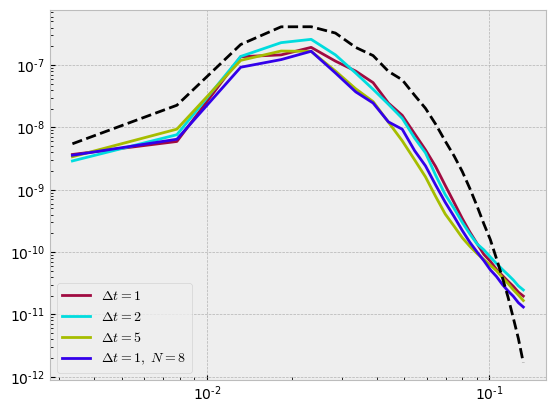

In [12]:
plt.loglog(enst_spec_1.freq_r,enst_spec_1,c=clist[0],label = r"$\Delta t = 1$")
plt.loglog(enst_spec_2.freq_r,enst_spec_2,c=clist[1],label = r"$\Delta t = 2$")
plt.loglog(enst_spec_5.freq_r,enst_spec_5,c=clist[2],label = r"$\Delta t = 5$")
plt.loglog(enst_spec_8.freq_r,enst_spec_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.loglog(enst_spec_true.freq_r,enst_spec_true,"--k")

plt.legend(loc= "lower left")

In [13]:
N_plot = 200

enst_1, enst_true = gen_enstrophy(N_plot,test_data,model_pred_1_short,dx, dy, Nb, wet_lap)
enst_1 = enst_1.mean(axis=(1,2))
enst_2, enst_true = gen_enstrophy(int(N_plot/2),test_data,model_pred_2_short,dx, dy, Nb, wet_lap)
enst_2 = enst_2.mean(axis=(1,2))
enst_5, enst_true = gen_enstrophy(int(N_plot/5),test_data,model_pred_5_short,dx, dy, Nb, wet_lap)
enst_5 = enst_5.mean(axis=(1,2))
enst_8, enst_true = gen_enstrophy(N_plot,test_data,model_pred_8_short,dx, dy, Nb, wet_lap)
enst_8 = enst_8.mean(axis=(1,2))
enst_true = enst_true.mean(axis=(1,2))




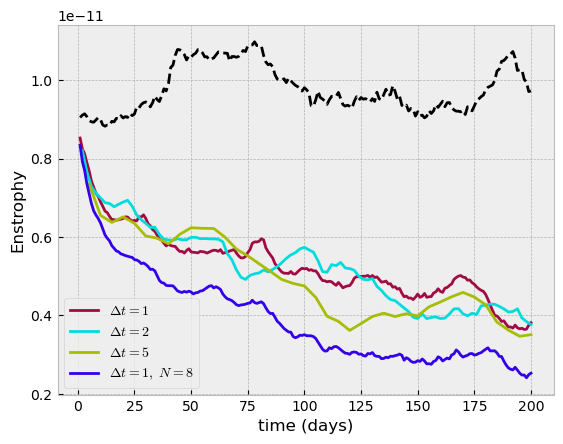

In [14]:

plt.plot(np.arange(1,N_plot+1),enst_1,c=clist[0],label = r"$\Delta t = 1$")
plt.plot(np.arange(2,N_plot+1,2),enst_2,c=clist[1],label = r"$\Delta t = 2$")
plt.plot(np.arange(5,N_plot+1,5),enst_5,c=clist[2],label = r"$\Delta t = 5$")
plt.plot(np.arange(1,N_plot+1),enst_8,c=clist[3],label = r"$\Delta t = 1,~ N = 8$")

plt.plot(np.arange(1,N_plot+1),enst_true,"--k")
plt.xlabel("time (days)")
plt.ylabel("Enstrophy")
plt.legend(loc= "lower left")

## Spatial Matching Statistics 


In [42]:

T_test = np.array(test_data[:][1][:,2]*std_out[2] +mean_out[2])

### Probability Distribution Function

Here we plot the probaility density function for a variable to get a sense of how well the model is capturing both the typpical dynamics as well as the extremes. Here we simply take the normalized historgram of the field over some number of days to smooth the PDF and look after the field has evolves for several time steps to get a sense of how the emulator has drifted from the ground truth. 


In [54]:
#T_PDF
var_list = {"1":r"$\bar{v}$ (m/s)","0":r"$\bar{u}$ (m/s)","2":r"$\bar{T}$ ~ $(^\circ C)$"}

ind_plot = 2
N_days = 2000
day_start = 1000

true_field = (test_data[day_start:day_start+N_days][1][:,ind_plot,wet_bool].flatten()*std_out[ind_plot])+mean_out[ind_plot]
true_field = np.array(true_field)
field_5 = (model_pred_5[day_start:day_start+N_days,wet_bool,ind_plot].flatten())
field_bad = (model_pred_bad[day_start:day_start+N_days,wet_bool,ind_plot].flatten())

true_pdf, bins_true = np.histogram(true_field,bins = 150,density = True);
pdf_5, bins_5 = np.histogram(field_5,bins = bins_true,density = True);
pdf_bad, bins_bad = np.histogram(field_bad,bins = bins_true,density = True);

bins_true = (bins_true[1:]+bins_true[:-1])/2
bins_5 = (bins_5[1:]+bins_5[:-1])/2
bins_bad = (bins_bad[1:]+bins_bad[:-1])/2

# correlation
print(np.corrcoef(true_pdf,pdf_5)[0,1])
# rmse
print(np.sqrt(((true_pdf-pdf_5)**2).mean()))

print(np.corrcoef(true_pdf,pdf_bad)[0,1])
print(np.sqrt(((true_pdf-pdf_bad)**2).mean()))

0.8815562676422138
0.028642852987974823
0.8846879543801113
0.029457689963287764


In [55]:
# T stats
print(r"Convnext: "+str(np.round(field_5.mean(),4))+ " std: " +str(np.round(field_5.std(),4))\
      +" skew:"+str(np.round(sp.stats.skew(field_5),4))+" kurt:"+str(np.round(sp.stats.kurtosis(field_5),4)))
print(r"Baseline: "+str(np.round(field_bad.mean(),4))+ " std: " +str(np.round(field_bad.std(),4))\
      +" skew:"+str(np.round(sp.stats.skew(field_bad),4))+" kurt:"+str(np.round(sp.stats.kurtosis(field_bad),4)))
print(r"CM2.6, mean: "+str(np.round(true_field.mean(),4))+ " std: " +str(np.round(true_field.std(),4))\
      +" skew:"+str(np.round(sp.stats.skew(true_field),4))+" kurt:"+str(np.round(sp.stats.kurtosis(true_field),4)))

Convnext: 13.0196 std: 11.0551 skew:-0.0405 kurt:-1.5371
Baseline: 13.6312 std: 11.1963 skew:-0.0785 kurt:-1.5299
CM2.6, mean: 13.0014 std: 11.1333 skew:-0.0411 kurt:-1.5425


In [57]:
#mean T
N_error = 1000

bias_T_5 = model_pred_5[:N_error,:,:,2].mean(axis=0) - T_test[:N_error].mean(axis=0)
bias_T_bad = model_pred_bad[:N_error,:,:,2].mean(axis=0) - T_test[:N_error].mean(axis=0)

mean_T_5 = model_pred_5[:N_error,:,:,2].mean(axis=0)
mean_T_bad = model_pred_bad[:N_error,:,:,2].mean(axis=0)

mean_T_true = T_test[:N_error].mean(axis=0)

cor_T_5 = (area_flat*mean_T_5[wet_bool].flatten()*mean_T_true[wet_bool].flatten()).sum()/np.sqrt((area_flat*mean_T_5[wet_bool].flatten()**2).sum()*(area_flat*mean_T_true[wet_bool].flatten()**2).sum())
rmse_T_5 = np.sqrt((area_flat*(mean_T_5[wet_bool].flatten()-mean_T_true[wet_bool].flatten())**2).sum()/area_flat.sum())

cor_T_bad = (area_flat*mean_T_bad[wet_bool].flatten()*mean_T_true[wet_bool].flatten()).sum()/np.sqrt((area_flat*mean_T_bad[wet_bool].flatten()**2).sum()*(area_flat*mean_T_true[wet_bool].flatten()**2).sum())
rmse_T_bad = np.sqrt((area_flat*(mean_T_bad[wet_bool].flatten()-mean_T_true[wet_bool].flatten())**2).sum()/area_flat.sum())

print(cor_T_5)
print(rmse_T_5)

print(cor_T_bad)
print(rmse_T_bad)


0.9998754062736018
0.3165927446615311
0.9995842679727702
0.7945407718914129


In [62]:
# Nino Index

Nino34 = grids["x_C"].loc[-5:5,360-170:360-150]
x_ind = [np.argwhere(grids.xu_ocean.data==Nino34["xu_ocean"][0].data),
        np.argwhere(grids.xu_ocean.data==Nino34["xu_ocean"][-1].data)]
x_ind = [x_ind[0][0][0],x_ind[1][0][0]]
y_ind = [np.argwhere(grids.yu_ocean.data==Nino34["yu_ocean"][0].data),
        np.argwhere(grids.yu_ocean.data==Nino34["yu_ocean"][-1].data)]
y_ind = [y_ind[0][0][0],y_ind[1][0][0]]
area_Nino = grids["area_C"].loc[-5:5,360-170:360-150]

T_5 = model_pred_5[:N_test,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1,2]
T_bad = model_pred_bad[:N_test,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1,2]

T_true = test_data[:][1][:,2,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1]
T_true = T_true*std_out[2]+mean_out[2]

def Nino_Index(T,time_test,area):
    T = xr.DataArray(
        data=T,
        dims=["time","yu_ocean", "xu_ocean"],
        coords=dict(
            time=time_test,        
            yu_ocean=(["yu_ocean"], area.yu_ocean.data),
            xu_ocean=(["xu_ocean"], area.xu_ocean.data)

            )
        )
    
    clim = T.groupby('time.dayofyear').mean('time').to_numpy()

    T_clim = T.copy()
    for i in range(time_test.size):
        day = int(time_test[i].dayofyr-1)
        T_clim[i] = (T[i]-clim[day]).data        

    T_clim = T_clim.rolling(time = 150).mean()
    T_clim = (T_clim*area).sum(["xu_ocean","yu_ocean"])/area.sum(["xu_ocean","yu_ocean"])

    return T_clim.to_numpy()

Nino_5 = Nino_Index(T_5,time_test,area_Nino)[150:]
Nino_bad = Nino_Index(T_bad,time_test,area_Nino)[150:]
Nino_true = Nino_Index(T_true,time_test,area_Nino)[150:]

print(np.corrcoef(Nino_true,Nino_5)[0,1])
print(np.sqrt(((Nino_true-Nino_5)**2).mean()))

print(np.corrcoef(Nino_true,Nino_bad)[0,1])
print(np.sqrt(((Nino_true-Nino_bad)**2).mean()))

0.9944054371726634
0.11494929002603288
0.9933672500381524
0.1354477180332243


In [63]:
# AMO Index

Nino34 = grids["x_C"].loc[0:80,283:]
x_ind = [np.argwhere(grids.xu_ocean.data==Nino34["xu_ocean"][0].data),
        np.argwhere(grids.xu_ocean.data==Nino34["xu_ocean"][-1].data)]
x_ind = [x_ind[0][0][0],x_ind[1][0][0]]
y_ind = [np.argwhere(grids.yu_ocean.data==Nino34["yu_ocean"][0].data),
        np.argwhere(grids.yu_ocean.data==Nino34["yu_ocean"][-1].data)]
y_ind = [y_ind[0][0][0],y_ind[1][0][0]]
area_Nino = grids["area_C"].loc[0:80,283:]

T_5 = model_pred_5[:N_test,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1,2]
T_bad = model_pred_bad[:N_test,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1,2]

T_true = test_data[:][1][:,2,y_ind[0]:y_ind[1]+1,x_ind[0]:x_ind[1]+1]
T_true = T_true*std_out[2]+mean_out[2]

def Nino_Index(T,time_test,area):
    T = xr.DataArray(
        data=T,
        dims=["time","yu_ocean", "xu_ocean"],
        coords=dict(
            time=time_test,        
            yu_ocean=(["yu_ocean"], area.yu_ocean.data),
            xu_ocean=(["xu_ocean"], area.xu_ocean.data)

            )
        )
    
    clim = T.groupby('time.dayofyear').mean('time').to_numpy()

    T_clim = T.copy()
    for i in range(time_test.size):
        day = int(time_test[i].dayofyr-1)
        T_clim[i] = (T[i]-clim[day]).data        

    T_clim = T_clim.rolling(time = 150).mean()
    T_clim = (T_clim*area).sum(["xu_ocean","yu_ocean"])/area.sum(["xu_ocean","yu_ocean"])

    return T_clim.to_numpy()

Nino_5 = Nino_Index(T_5,time_test,area_Nino)[150:]
Nino_bad = Nino_Index(T_bad,time_test,area_Nino)[150:]
Nino_true = Nino_Index(T_true,time_test,area_Nino)[150:]

print(np.corrcoef(Nino_true,Nino_5)[0,1])
print(np.sqrt(((Nino_true-Nino_5)**2).mean()))

print(np.corrcoef(Nino_true,Nino_bad)[0,1])
print(np.sqrt(((Nino_true-Nino_bad)**2).mean()))

0.9335585670333338
0.031549115818445696
0.9502155996567044
0.02280938616004946
